In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Load data

In [2]:
def numerify(var):
    """
    Cast an object as an int or float if possible. Otherwise return unmodified
    """
    
    if isinstance(var, str):
        try:
            var = int(var)

        except:
            try:
                var = float(var)
            except:
                pass
    else:
        pass
            
    return var

In [3]:
#write a nice data loader
#should return metadata as a dict, data in a pandas df


def read_1D_data(fp):
    """
    Read a 1D Xenocs data .dat file
    """
    metadata = {}
    q = []
    I = []
    sig = []
    header_count = 0

    in_data = False # flag for if we are read into data yet

    with open(fp, 'rt') as f:
        for line in f:
            if not in_data:
                if line[:2] == '##': #metadata section header 
                    header_count +=1
                    continue
                elif line[:2] == '# ':
                    items = line.split()
                    metadata[items[1]] = numerify(items[2])

                elif line[0] == 'q' and header_count == 2:
                    in_data = True
            elif in_data:
                vals = line.split()
                q.append(numerify(vals[0]))
                I.append(numerify(vals[1]))
                sig.append(numerify(vals[2]))


    data = pd.DataFrame({'q':q, 'I':I, 'sig':sig})
    
    return data, metadata
                

        

In [4]:
esaxs_data, esaxs_metadata = read_1D_data('data/Data_0_00002.dat')
saxs_data, saxs_metadata = read_1D_data('data/Data_0_00016.dat')
maxs_data, maxs_metadata = read_1D_data('data/Data_0_00030.dat')

esaxs_bkg_data, esaxs_bkg_metadata = read_1D_data('data/Data_0_00012.dat')
saxs_bkg_data, saxs_bkg_metadata = read_1D_data('data/Data_0_00026.dat')
maxs_bkg_data, maxs_bkg_metadata = read_1D_data('data/Data_0_00040.dat')

## 2. Subtract background

In [5]:
def find_ratio_peak(ratio_avg):
    """
    Find max value of ratio using max
    Returns index of peak
    """
    
    avg_copy = ratio_avg.copy()
    avg_copy[avg_copy == np.inf] = 0
    ind = np.nanargmax(avg_copy)
    
    return ind

In [6]:
def ratio_running_average(a, b, n_pts = 10):
    """
    Calculate the running average of the ratio of signal to background
    
    a - signal data. 1d array
    b - background data. 1d array
    """
    
    assert len(a) == len(b), 'a and b must have same number of elements'
    
    ratio = a/b
    
    running_average = np.convolve(ratio, np.ones(n_pts)/n_pts, mode = 'same')
    
    return running_average
    
    

In [7]:
def scale_data(data1, data2, scale_qmin, scale_qmax):
    """
    scale data2 onto data1 using a scale factor calculated from the difference in integrals of data1 and data2 over the range scale_qmin -> scale_qmax
    """

    # get yvals for each dataset
    inrange_data1 = data1[data1['q'].between(scale_qmin, scale_qmax, inclusive = 'both')]
    inrange_data2 = data2[data2['q'].between(scale_qmin, scale_qmax, inclusive = 'both')]

    assert np.isclose(inrange_data1['q'].iloc[0], inrange_data2['q'].iloc[0])
    assert np.isclose(inrange_data1['q'].iloc[-1], inrange_data2['q'].iloc[-1])


    x1 = inrange_data1['q'].to_numpy()
    x2 = inrange_data2['q'].to_numpy()
    y1 = inrange_data1['I'].to_numpy()
    y2 = inrange_data2['I'].to_numpy()
    #check for nans in y values

    #trapezoid rule integrate
    scale1 = np.trapz(y1, x1)/(x1[-1] - x1[0])
    scale2 = np.trapz(y2, x2)/(x2[-1] - x2[0])

    scale_factor = scale1/scale2


    # scale data2 with scale factor
    data2_out = data2.copy()

    data2_out['I'] = data2['I']*scale_factor

    return data2_out


In [21]:
def subtract_background(data, background, scale_background = False, scale_qmin = 1e-4, scale_qmax = 1e-3):

    # check that q values line up for everything
    assert np.isclose(data['q'].to_numpy(), background['q'].to_numpy()).all()
    # once we get fancier look into allowance for slop or interpolation options. For now throw out anything not compliant ^^
    
    if scale_background:
        background = scale_data(data, background, scale_qmin, scale_qmax)
        
    subtracted_I = data['I'] - background['I']

    subtracted_data = data.copy()

    subtracted_data['I'] = subtracted_I
    
    return subtracted_data

In [22]:
def select_valid_data(signal, background, lowq_thresh = 5, hiq_thresh = 5, hiq_avg_pts = 10):
    """
    Find the region of valid data in SAXS signal
    
    Considers the ratio of signal to background to identify regions with enough scattering to provide information
    
    Parameters:
    -----------
    signal (DataFrame): signal saxs data
    background (DataFrame): corresponding background
    lowq_thresh: multiplier threshold for low q limit. Signal must be low_thresh times larger than background to find low q limit
    hiq_thresh: threshold for hiq limit
    hiq_avg_pts: how many data points to take a running average over when considering thresholds.
    """

    assert len(signal) == len(background), 'Signal and background data sets need to have same number of data points'

    q = signal['q']

    lowq_lim = None
    hiq_lim = None

    last_n_ratios = []
    rolling_average_ratio = ratio_running_average(signal['I'], background['I'], n_pts = hiq_avg_pts)

    # need to find peak to engage hi-q limit finder
    ratio_peak_ind = find_ratio_peak(rolling_average_ratio)



    for i, ratio in enumerate(rolling_average_ratio):
        if ratio > lowq_thresh:
            if lowq_lim is None:
                lowq_lim = i


        if lowq_lim is not None:
            if i > ratio_peak_ind:
                if ratio < hiq_thresh:
                    if hiq_lim is None:
                        hiq_lim = i
                        break

    return lowq_lim, hiq_lim


In [23]:
def chop_subtract(signal, background, lowq_thresh = 5, hiq_thresh = 5, hiq_avg_pts = 10, scale = False):
    """
    wrapper function to handle subtraction and valid data selection 
    """
    assert np.isclose(signal['q'].to_numpy(), background['q'].to_numpy()).all()

    loq, hiq = select_valid_data(signal, background, lowq_thresh = lowq_thresh, hiq_thresh= hiq_thresh, hiq_avg_pts = hiq_avg_pts)

    subtracted_signal = subtract_background(signal, background, scale_background = False)

    chopped_subtracted = subtracted_signal.iloc[loq:hiq]

    return chopped_subtracted


In [30]:
cleaned_esaxs = chop_subtract(esaxs_data, esaxs_bkg_data)
cleaned_saxs = chop_subtract(saxs_data, saxs_bkg_data)
cleaned_maxs = chop_subtract(maxs_data, maxs_bkg_data)

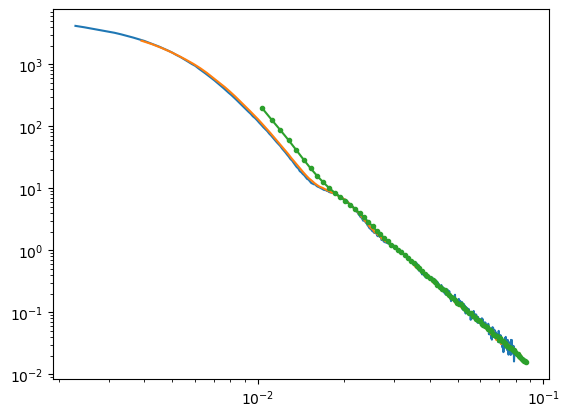

In [31]:
plt.loglog(cleaned_esaxs['q'], cleaned_esaxs['I'])
plt.loglog(cleaned_saxs['q'], cleaned_saxs['I'])
plt.loglog(cleaned_maxs['q'], cleaned_maxs['I'], marker = '.')

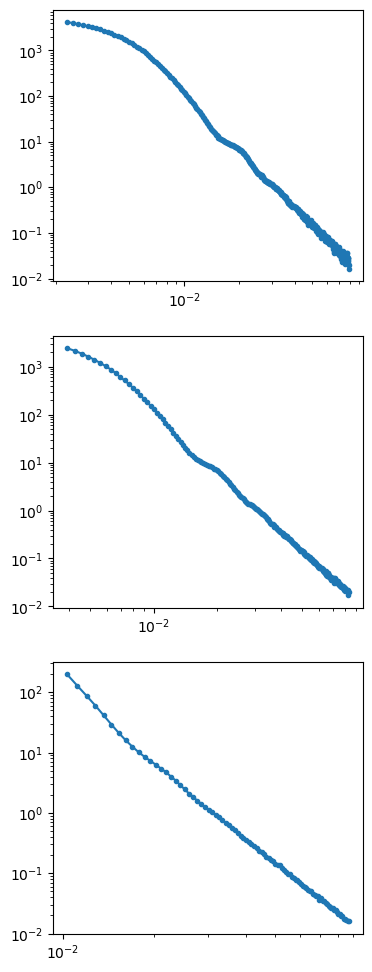

In [49]:
fig, ax = plt.subplots(3,1, figsize = (4, 12))

ax[0].loglog(cleaned_esaxs['q'], cleaned_esaxs['I'], marker = '.')
ax[1].loglog(cleaned_saxs['q'], cleaned_saxs['I'], marker = '.')
ax[2].loglog(cleaned_maxs['q'], cleaned_maxs['I'], marker = '.')

In [43]:
esaxs_data[esaxs_data['q'].isin(saxs_data['q'])]

,q,I,sig


In [55]:
1e-2

0.01

In [47]:
cleaned_esaxs['q']

13     0.002292
14     0.002462
15     0.002632
16     0.002802
17     0.002971
         ...   
461    0.078359
462    0.078528
463    0.078698
464    0.078868
465    0.079038
Name: q, Length: 453, dtype: float64

In [48]:
cleaned_saxs['q'].iloc[175:225]

186    0.063332
187    0.063672
188    0.064011
189    0.064351
190    0.064691
191    0.065030
192    0.065370
193    0.065709
194    0.066049
195    0.066388
196    0.066728
197    0.067068
198    0.067407
199    0.067747
200    0.068086
201    0.068426
202    0.068766
203    0.069105
204    0.069445
205    0.069784
206    0.070124
207    0.070463
208    0.070803
209    0.071143
210    0.071482
211    0.071822
212    0.072161
213    0.072501
214    0.072841
215    0.073180
216    0.073520
217    0.073859
218    0.074199
219    0.074538
220    0.074878
221    0.075218
222    0.075557
223    0.075897
224    0.076236
225    0.076576
226    0.076916
227    0.077255
228    0.077595
229    0.077934
230    0.078274
231    0.078613
232    0.078953
233    0.079293
234    0.079632
235    0.079972
Name: q, dtype: float64

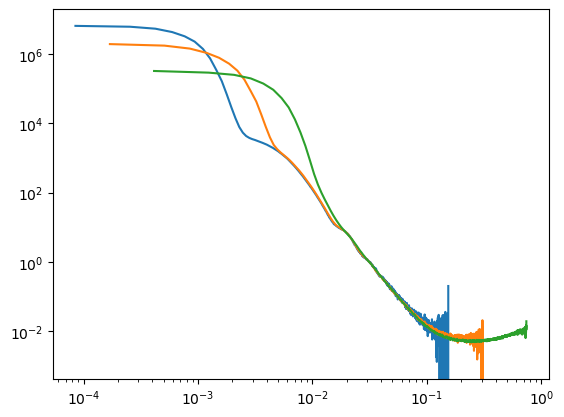

In [32]:
plt.loglog(esaxs_data['q'], esaxs_data['I'])
plt.loglog(saxs_data['q'], saxs_data['I'])
plt.loglog(maxs_data['q'], maxs_data['I'])

In [33]:
#figure out range of data to keep 

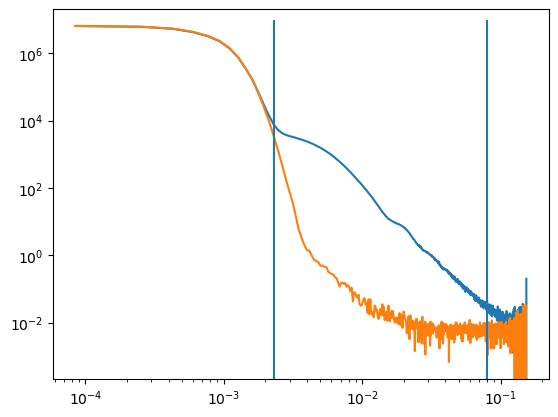

In [34]:
signal = esaxs_data
background = esaxs_bkg_data


loq, hiq = select_valid_data(signal, background, lowq_thresh = 5)

fig, ax = plt.subplots()



ax.loglog(signal['q'], signal['I'])
ax.loglog(background['q'], background['I'])


#ax1.loglog(esaxs_data['q'][1:], ratio_diff, c = 'g')
#ax1.loglog(esaxs_data['q'], rolling_average_ratio)

ax.vlines(signal['q'][loq], 0, 10e6)
ax.vlines(signal['q'][hiq], 0, 10e6)
#ax.vlines(q_peak, 0, 10e6, color = 'r')

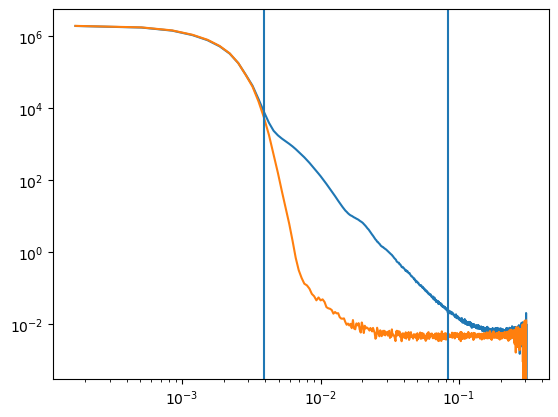

In [35]:
signal = saxs_data
background = saxs_bkg_data


loq, hiq = select_valid_data(signal, background, lowq_thresh = 5)

fig, ax = plt.subplots()



ax.loglog(signal['q'], signal['I'])
ax.loglog(background['q'], background['I'])


#ax1.loglog(esaxs_data['q'][1:], ratio_diff, c = 'g')
#ax1.loglog(esaxs_data['q'], rolling_average_ratio)

ax.vlines(signal['q'][loq], 0, 10e6)
ax.vlines(signal['q'][hiq], 0, 10e6)
#ax.vlines(q_peak, 0, 10e6, color = 'r')

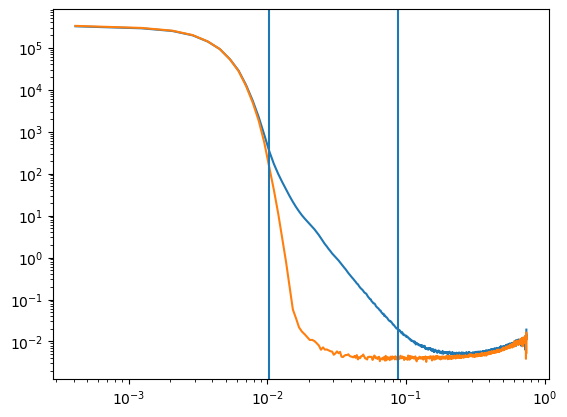

In [36]:
signal = maxs_data
background = maxs_bkg_data


loq, hiq = select_valid_data(signal, background, lowq_thresh = 5)

fig, ax = plt.subplots()



ax.loglog(signal['q'], signal['I'])
ax.loglog(background['q'], background['I'])


#ax1.loglog(esaxs_data['q'][1:], ratio_diff, c = 'g')
#ax1.loglog(esaxs_data['q'], rolling_average_ratio)

ax.vlines(signal['q'][loq], 0, 10e6)
ax.vlines(signal['q'][hiq], 0, 10e6)
#ax.vlines(q_peak, 0, 10e6, color = 'r')

## 3. Data merge

In [ ]:
#1. Figure out 'good' range for each data

#low end: this is hard. probably use hard-coded qmin for now

#upper end: do some sort of noise quantification. Maybe max-min over last 3 data points < 5% of average value? 

# 2. determine overlapping range for the 2 data sets

#3. Looking within overlapping range, apply rules to figure something out

    # - slopes should match
    # - values should be close 
    
    

In [79]:
low_q_limit = 0.01
hi_q_limit = 0.03

low_q_source = 'esaxs'
hi_q_source = 'saxs'

low_q_data = cleaned_esaxs
hi_q_data = cleaned_saxs

def splice_datasets(low_q_data, hi_q_data, low_q_limit, high_q_limit, low_q_source, hi_q_source):
    """
    Splice together low_q_data and hi_q_data. At q<lo_q_limit, only low_q_data included. Above hi_q_limit, only hi_q_data included. Between lo_q and hi_q limits, both datasets included
    """
    low_q_include = low_q_data[low_q_data['q'] < hi_q_limit].copy()
    hi_q_include = hi_q_data[hi_q_data['q'] > low_q_limit].copy()

    low_q_include['source'] = low_q_source
    hi_q_include['source'] = hi_q_source

    spliced_data = pd.concat([low_q_include, hi_q_include]).sort_values('q')

    return spliced_data


In [84]:
#def find_overlap(data1, data2):

data1 = cleaned_esaxs
data2 = cleaned_saxs

data1_qmax = data1['q'].max()
data1_qmin = data1['q'].min()

data2_qmax = data2['q'].max()
data2_qmin = data2['q'].min()

# for overlap:
if data1_qmax > data2_qmin or data1_qmin < data2_qmax:
    # we have some overlap, one could be entirely contained
    # figure out if strictly overlap or contined
    
    



# return regions of each dataset that are strictly within the other 

# raise error if there is no everlap

True

In [82]:
#def interpolate_on_q(data, q_grid):
q_grid = cleaned_esaxs['q']

# get overlapping regions
donor_grid = cleaned_saxs['q']

#low q: q on donor grid such at next biggest q is 'in' target grid'
donor[donor_grid < q_grid.min()]


# within overlapping regions:

# need to assign an I value to each q on q grid

# iterate over q_grid and linear interpolate q at each q_grid point




Series([], Name: q, dtype: float64)

In [66]:
low_q_include['source'] =  'esaxs'

In [67]:
low_q_include

,q,I,sig,source
13,0.002292,4197.308413,10.742488,esaxs
14,0.002462,3983.665166,7.994859,esaxs
15,0.002632,3768.83247,7.150804,esaxs
16,0.002802,3580.285668,6.718719,esaxs
17,0.002971,3401.373291,6.092482,esaxs
...,...,...,...,...
173,0.029459,1.19516,0.037885,esaxs
174,0.029629,1.160621,0.03722,esaxs
175,0.029798,1.168334,0.037251,esaxs
176,0.029968,1.195914,0.03713,esaxs


In [82]:
#iterate over values in I
last_3_Is = []
variance = []
avg = []
ranges = []


for i, row in data1.iterrows():
    I = row['I']
    if i < 5:
        last_3_Is.append(I)
        continue
    else:
        
        if i == 100:
            print(len(last_3_Is))
        
        last_3_Is.append(I)
        
        Imin = min(last_3_Is)
        Imax = max(last_3_Is)
        Iavg = np.log(np.mean(last_3_Is))
        
        Irange = np.log(Imax) - np.log(Imin)
        avg.append(Iavg)
        ranges.append(Iavg)
        
        var = Irange/Iavg
        
        variance.append(var)
        last_3_Is.pop(0)
        
        
        

# For last 3 values, get min and max val

# min-max should be less than x % of average of last 3 values 


5


/tmp/ipykernel_5466/1559568081.py:24: RuntimeWarning: divide by zero encountered in log
  Irange = np.log(Imax) - np.log(Imin)
/tmp/ipykernel_5466/1559568081.py:22: RuntimeWarning: divide by zero encountered in log
  Iavg = np.log(np.mean(last_3_Is))
/tmp/ipykernel_5466/1559568081.py:24: RuntimeWarning: invalid value encountered in scalar subtract
  Irange = np.log(Imax) - np.log(Imin)


In [83]:
Irange

inf

In [84]:
Iavg

-3.4020933544839136

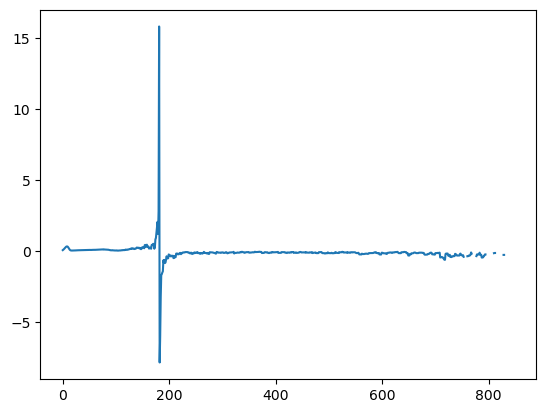

In [85]:
plt.plot(variance)

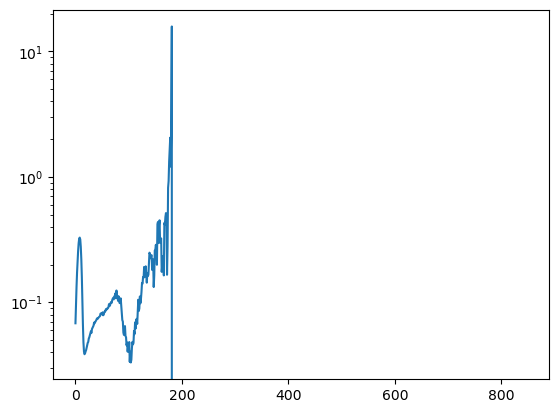

In [86]:
plt.semilogy(variance)

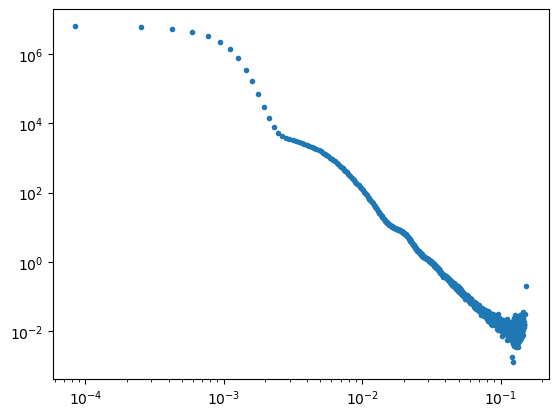

In [81]:
plt.loglog(data1['q'], data1['I'], ls = ' ', marker = '.')